In [1]:
import numpy as np
np.random.seed(2345)

import pandas as pd

In [2]:
questions = pd.read_csv("./input/Questions.csv", encoding='latin1')
answers = pd.read_csv("./input/Answers.csv", encoding='latin1')
tags = pd.read_csv("./input/Tags.csv", encoding='latin1')

In [3]:
tags.head()

,Id,Tag
0,77434,vector
1,79709,memory
2,79709,function
3,79709,global-variables
4,79709,side-effects


In [4]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,IsAcceptedAnswer,Body
0,79741,3259.0,2008-09-17T03:43:22Z,79709,-1,False,<p>It's tough to say definitively without know...
1,79768,6043.0,2008-09-17T03:48:29Z,79709,5,False,<p>use variables in the outer function instead...
2,79779,8002.0,2008-09-17T03:49:36Z,79709,0,False,<p>Third approach: inner function returns a re...
3,79788,NaN,2008-09-17T03:51:30Z,79709,3,False,<p>It's not going to make much difference to m...
4,79827,14257.0,2008-09-17T03:58:26Z,79709,1,False,"<p>I'm not sure I understand the question, but..."


In [5]:
questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,77434,14008.0,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,<p>Suppose I have a vector that is nested in a...
1,79709,NaN,2008-09-17T03:39:16Z,1,Worse sin: side effects or passing massive obj...,<p>I have a function inside a loop inside a fu...
2,95007,15842.0,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,<p>I've been mystified by the R quantile funct...
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,<p>How can I test for the <code>EOF</code> fla...
4,255697,1941213.0,2008-11-01T15:48:30Z,3,Is there an R package for learning a Dirichlet...,<p>I'm looking for a an <code>R</code> package...


In [6]:
questions.info() # Id Title Body are used for constructing the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147075 entries, 0 to 147074
Data columns (total 6 columns):
Id              147075 non-null int64
OwnerUserId     146129 non-null float64
CreationDate    147075 non-null object
Score           147075 non-null int64
Title           147075 non-null object
Body            147075 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 6.7+ MB


In [7]:
answers.info() # OwnerUserId ParentId IsAcceptedAnswer are used for constructing the dataset, maybe score can be used in the future

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198592 entries, 0 to 198591
Data columns (total 7 columns):
Id                  198592 non-null int64
OwnerUserId         197964 non-null float64
CreationDate        198592 non-null object
ParentId            198592 non-null int64
Score               198592 non-null int64
IsAcceptedAnswer    198592 non-null bool
Body                198592 non-null object
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 9.3+ MB


In [8]:
tags.info() # Id and Tag are useful

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241546 entries, 0 to 241545
Data columns (total 2 columns):
Id     241546 non-null int64
Tag    241485 non-null object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


**先处理questions，数据清洗**

In [9]:
# extract all the code part 
temp_code = questions['Body'].str.extractall(r'(<code>[^<]+</code>)')

In [10]:
temp_code.head()

0
  match                                                   
0 0                                  <code>length()</code>
  1                                        <code>$#</code>
  2                       <code>dat$vec1$vec2[$#]\n</code>
  3      <code>dat$vec1$vec2[length(dat$vec1$vec2)]\n</...
1 0      <code>for (dataset in list_of_datasets) {\n  f...

In [11]:
# unstack and convert into a single column for cleaning
test = temp_code.unstack('match')

test.columns = test.columns.droplevel()
# put all columns together
code = pd.DataFrame(test.apply(lambda x: x.str.cat(), axis=1,reduce=True))
# rename 
code.columns = ['CodeBody']
# remove the html tags finally
code['CodeBody'] = code['CodeBody'].str.replace(r'<[^>]+>|\n|\r',' ')

In [12]:
# remove the code part from questions
body = questions['Body'].str.replace(r'<code>[^<]+</code>',' ')
# build up the question part from questions
questions['QuestionBody'] = body.str.replace(r"<[^>]+>|\n|\r", " ")

In [13]:
# Join the codebody by index
questions = questions.join(code)
# final cleaned dataset
questions_final = questions.drop('Body',axis=1)

In [14]:
questions_final.head()

,Id,OwnerUserId,CreationDate,Score,Title,QuestionBody,CodeBody
0,77434,14008.0,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...
1,79709,NaN,2008-09-17T03:39:16Z,1,Worse sin: side effects or passing massive obj...,I have a function inside a loop inside a func...,for (dataset in list_of_datasets) { for (da...
2,95007,15842.0,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,How can I test for the flag in R? For e...,"EOF f &lt;- file(fname, ""rb"") while (???) { ..."
4,255697,1941213.0,2008-11-01T15:48:30Z,3,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R


In [15]:
questions_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147075 entries, 0 to 147074
Data columns (total 7 columns):
Id              147075 non-null int64
OwnerUserId     146129 non-null float64
CreationDate    147075 non-null object
Score           147075 non-null int64
Title           147075 non-null object
QuestionBody    147075 non-null object
CodeBody        134507 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 7.9+ MB


**再处理tags,将其拼在questions后**

In [16]:
tags = tags[tags.Tag.notnull()]

In [17]:
tagsByquestion = tags.groupby('Id',as_index=False).agg(lambda x: ' '.join(x))

In [18]:
tagsByquestion.head()

,Id,Tag
0,77434,vector
1,79709,memory function global-variables side-effects
2,95007,math statistics
3,103312,file file-io eof
4,255697,math statistics bayesian dirichlet


In [19]:
tagsByquestion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121862 entries, 0 to 121861
Data columns (total 2 columns):
Id     121862 non-null int64
Tag    121862 non-null object
dtypes: int64(1), object(1)
memory usage: 2.8+ MB


In [20]:
questions_tags = questions_final.merge(tagsByquestion,on='Id',how='left')

In [21]:
questions_tags.head()

,Id,OwnerUserId,CreationDate,Score,Title,QuestionBody,CodeBody,Tag
0,77434,14008.0,2008-09-16T21:40:29Z,134,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...,vector
1,79709,NaN,2008-09-17T03:39:16Z,1,Worse sin: side effects or passing massive obj...,I have a function inside a loop inside a func...,for (dataset in list_of_datasets) { for (da...,memory function global-variables side-effects
2,95007,15842.0,2008-09-18T17:59:19Z,48,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics
3,103312,NaN,2008-09-19T16:09:26Z,4,How to test for the EOF flag in R?,How can I test for the flag in R? For e...,"EOF f &lt;- file(fname, ""rb"") while (???) { ...",file file-io eof
4,255697,1941213.0,2008-11-01T15:48:30Z,3,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R,math statistics bayesian dirichlet


In [22]:
questions_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147075 entries, 0 to 147074
Data columns (total 8 columns):
Id              147075 non-null int64
OwnerUserId     146129 non-null float64
CreationDate    147075 non-null object
Score           147075 non-null int64
Title           147075 non-null object
QuestionBody    147075 non-null object
CodeBody        134507 non-null object
Tag             121862 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 10.1+ MB


至此，Questions和tags处理并合并完成。

In [23]:
questions_tags = questions_tags.drop(['OwnerUserId','CreationDate','Score'], axis=1)

In [24]:
questions_tags.head()

,Id,Title,QuestionBody,CodeBody,Tag
0,77434,How to access the last value in a vector?,Suppose I have a vector that is nested in a d...,length() $# dat$vec1$vec2[$#] dat$vec1$ve...,vector
1,79709,Worse sin: side effects or passing massive obj...,I have a function inside a loop inside a func...,for (dataset in list_of_datasets) { for (da...,memory function global-variables side-effects
2,95007,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics
3,103312,How to test for the EOF flag in R?,How can I test for the flag in R? For e...,"EOF f &lt;- file(fname, ""rb"") while (???) { ...",file file-io eof
4,255697,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R,math statistics bayesian dirichlet


In [25]:
questions_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147075 entries, 0 to 147074
Data columns (total 5 columns):
Id              147075 non-null int64
Title           147075 non-null object
QuestionBody    147075 non-null object
CodeBody        134507 non-null object
Tag             121862 non-null object
dtypes: int64(1), object(4)
memory usage: 6.7+ MB


**再处理answers，找出有最佳回答的问题**

In [26]:
accepted_answers = answers[answers.IsAcceptedAnswer == True]

In [27]:
accepted_answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,IsAcceptedAnswer,Body
12,255992,23263.0,2008-11-01T19:29:54Z,255697,2,True,<p>I've only come across both R and the Dirich...
13,359458,3201.0,2008-12-11T14:06:56Z,359438,2,True,"<p>I have used <a href=""http://cran.r-project...."
15,440066,37751.0,2009-01-13T18:00:54Z,439526,8,True,<p>Clearly I should have worked on this for an...
18,455286,54904.0,2009-01-18T15:12:24Z,445059,7,True,<p>Here's what seems like another very R-type ...
19,467131,57626.0,2009-01-21T21:38:10Z,467110,11,True,<p>In most cases R is an interpreted language ...


In [28]:
accepted_answers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87661 entries, 12 to 198588
Data columns (total 7 columns):
Id                  87661 non-null int64
OwnerUserId         87404 non-null float64
CreationDate        87661 non-null object
ParentId            87661 non-null int64
Score               87661 non-null int64
IsAcceptedAnswer    87661 non-null bool
Body                87661 non-null object
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 4.8+ MB


In [29]:
%matplotlib inline

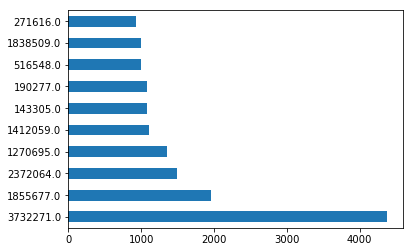

In [30]:
# Let's compute the number of best answers the experts have proposed:
accepted_answers["OwnerUserId"].value_counts().head(10).plot(kind="barh")

In [31]:
accepted_answers["OwnerUserId"].value_counts().head(10)

3732271.0    4380
1855677.0    1954
2372064.0    1495
1270695.0    1360
1412059.0    1102
143305.0     1083
190277.0     1075
516548.0      995
1838509.0     991
271616.0      927
Name: OwnerUserId, dtype: int64

In [32]:
accepted_answers = accepted_answers.drop(['Id','CreationDate','Score','IsAcceptedAnswer' ,'Body'], axis=1)

In [33]:
col_mapping = {'OwnerUserId' : 'ExpertId',
               'ParentId' : 'Id'}
accepted_answers = accepted_answers.rename(columns=col_mapping, copy = False)

In [34]:
accepted_answers.head()

,ExpertId,Id
12,23263.0,255697
13,3201.0,359438
15,37751.0,439526
18,54904.0,445059
19,57626.0,467110


In [35]:
accepted_answers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87661 entries, 12 to 198588
Data columns (total 2 columns):
ExpertId    87404 non-null float64
Id          87661 non-null int64
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [36]:
accepted_answers = accepted_answers.dropna()

In [37]:
accepted_answers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87404 entries, 12 to 198588
Data columns (total 2 columns):
ExpertId    87404 non-null float64
Id          87404 non-null int64
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [38]:
unique_expert = accepted_answers.ExpertId.unique()
unique_expert.shape

(9004L,)

In [39]:
count = accepted_answers['ExpertId'].value_counts()

In [40]:
count_df = pd.DataFrame(count)

In [41]:
count_df = count_df.reset_index()

In [42]:
col_mapping2 = {'ExpertId' : 'Count',
                'index' : 'ExpertId'}
count_df = count_df.rename(columns=col_mapping2, copy = False)

In [43]:
count_df.head()

,ExpertId,Count
0,3732271.0,4380
1,1855677.0,1954
2,2372064.0,1495
3,1270695.0,1360
4,1412059.0,1102


In [44]:
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9004 entries, 0 to 9003
Data columns (total 2 columns):
ExpertId    9004 non-null float64
Count       9004 non-null int64
dtypes: float64(1), int64(1)
memory usage: 140.8 KB


**整合数据**

In [45]:
questions_answers = questions_tags.merge(accepted_answers,on='Id',how='right')

In [46]:
questions_answers.head()

,Id,Title,QuestionBody,CodeBody,Tag,ExpertId
0,95007,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics,79513.0
1,255697,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R,math statistics bayesian dirichlet,23263.0
2,359438,Optimization packages for R,Does anyone know of any optimization packages...,NaN,mathematical-optimization,3201.0
3,439526,Thinking in Vectors with R,I know that R works most efficiently with vec...,st p1 p2 st&lt;-NULL p1&lt;-NULL p2&lt;-NU...,vector,37751.0
4,445059,Vectorize my thinking: Vector Operations in R,So earlier I answered my own question on thin...,for (j in my.data$item[my.data$fixed==0]) { #...,vector,54904.0


In [47]:
questions_answers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87404 entries, 0 to 87403
Data columns (total 6 columns):
Id              87404 non-null int64
Title           87404 non-null object
QuestionBody    87404 non-null object
CodeBody        81701 non-null object
Tag             71861 non-null object
ExpertId        87404 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 4.7+ MB


In [48]:
experts_count = questions_answers.merge(count_df, on='ExpertId', how='left')

In [49]:
experts_count.head()

,Id,Title,QuestionBody,CodeBody,Tag,ExpertId,Count
0,95007,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics,79513.0,1
1,255697,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R,math statistics bayesian dirichlet,23263.0,1
2,359438,Optimization packages for R,Does anyone know of any optimization packages...,NaN,mathematical-optimization,3201.0,1
3,439526,Thinking in Vectors with R,I know that R works most efficiently with vec...,st p1 p2 st&lt;-NULL p1&lt;-NULL p2&lt;-NU...,vector,37751.0,53
4,445059,Vectorize my thinking: Vector Operations in R,So earlier I answered my own question on thin...,for (j in my.data$item[my.data$fixed==0]) { #...,vector,54904.0,1


In [50]:
experts_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87404 entries, 0 to 87403
Data columns (total 7 columns):
Id              87404 non-null int64
Title           87404 non-null object
QuestionBody    87404 non-null object
CodeBody        81701 non-null object
Tag             71861 non-null object
ExpertId        87404 non-null float64
Count           87404 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 5.3+ MB


In [51]:
experts_count.columns

Index([u'Id', u'Title', u'QuestionBody', u'CodeBody', u'Tag', u'ExpertId',
       u'Count'],
      dtype='object')

In [52]:
experts_count = experts_count.reindex(columns=[u'Id', u'Title', u'QuestionBody', u'CodeBody', u'Tag', u'ExpertId',
       u'Count', u'Label'])

In [53]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
experts_count['Label']=label.fit_transform(experts_count['ExpertId'])

In [54]:
experts_count.head()

,Id,Title,QuestionBody,CodeBody,Tag,ExpertId,Count,Label
0,95007,Explain the quantile() function in R,I've been mystified by the R quantile functio...,NaN,math statistics,79513.0,1,218
1,255697,Is there an R package for learning a Dirichlet...,I'm looking for a an package which can be u...,R R,math statistics bayesian dirichlet,23263.0,1,91
2,359438,Optimization packages for R,Does anyone know of any optimization packages...,NaN,mathematical-optimization,3201.0,1,15
3,439526,Thinking in Vectors with R,I know that R works most efficiently with vec...,st p1 p2 st&lt;-NULL p1&lt;-NULL p2&lt;-NU...,vector,37751.0,53,121
4,445059,Vectorize my thinking: Vector Operations in R,So earlier I answered my own question on thin...,for (j in my.data$item[my.data$fixed==0]) { #...,vector,54904.0,1,163


In [55]:
max_lable = np.max(experts_count.Label)
min_lable = np.min(experts_count.Label)
print (max_lable)
print (min_lable)

9003
0


In [56]:
experts_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87404 entries, 0 to 87403
Data columns (total 8 columns):
Id              87404 non-null int64
Title           87404 non-null object
QuestionBody    87404 non-null object
CodeBody        81701 non-null object
Tag             71861 non-null object
ExpertId        87404 non-null float64
Count           87404 non-null int64
Label           87404 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 6.0+ MB


In [57]:
import pickle
pickle.dump(experts_count,open('experts_count.pkl','wb'))

----

## **数据整合完毕，开始构造实验数据集**

start from here

In [1]:
import numpy as np
import pandas as pd
experts_count=pd.read_pickle('experts_count.pkl')
experts_count=experts_count.fillna('none')

In [2]:
experts_count.columns

Index([u'Id', u'Title', u'QuestionBody', u'CodeBody', u'Tag', u'ExpertId',
       u'Count', u'Label'],
      dtype='object')

In [3]:
train1 = experts_count[:80000][experts_count.Count>10]
test1 = experts_count[80000:]

C:\Users\Administrator\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [4]:
train1_unique_expert = train1.ExpertId.unique()
print ("number of experts in train set: %r " % train1_unique_expert.shape)

test1_unique_expert = test1.ExpertId.unique()
print ("number of experts in test set: %r" % test1_unique_expert.shape)

print ("type : %r" % type(test1_unique_expert))

l = np.intersect1d(train1_unique_expert,test1_unique_expert)
print ("the number of experts both in train set and test set: %r" % l.shape)

number of experts in train set: 818L 
number of experts in test set: 1417L
type : <type 'numpy.ndarray'>
the number of experts both in train set and test set: 377L


In [5]:
title_train1 = train1.drop(['Id','QuestionBody','CodeBody','Tag', \
                           'ExpertId','Count',],axis=1)
title_test1 = test1.drop(['Id','QuestionBody','CodeBody','Tag', \
                         'ExpertId','Count',],axis=1)

In [6]:
title_train1 = title_train1.set_index('Label')
title_test1 = title_test1.set_index('Label')

In [7]:
title_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66235 entries, 121 to 7823
Data columns (total 1 columns):
Title    66235 non-null object
dtypes: object(1)
memory usage: 1.0+ MB


In [8]:
title_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7404 entries, 7745 to 1871
Data columns (total 1 columns):
Title    7404 non-null object
dtypes: object(1)
memory usage: 115.7+ KB


In [9]:
# 通过fastText的测试类别我们得出，测试集中7404个问题中有5176个属于训练集中存在的专家
5176/7404.0

0.6990815775256618

In [10]:
title_train1.to_csv('title_train1', encoding='utf-8')
title_test1.to_csv('title_test1', encoding='utf-8')

**至此，数据集title_set1——Count>10构造完成！ used for classification model** 

- stop words were not ignored
- text was not tokenized and lowercased
- no stemming was used

----

*****

## **Now, let's contruct the dataset for computing the similarity **
start from here

In [1]:
import numpy as np
import pandas as pd
experts_count=pd.read_pickle('experts_count.pkl')
experts_count=experts_count.fillna('none')

In [2]:
train = experts_count[:80000]
test = experts_count[80000:]
title_train = train.drop(['Id','QuestionBody','CodeBody','Tag', \
                           'ExpertId','Count',],axis=1)
title_test = test.drop(['Id','QuestionBody','CodeBody','Tag', \
                         'ExpertId','Count',],axis=1)

In [3]:
title_train = title_train.groupby('Label',as_index=True).agg(lambda x: ' '.join(x))
title_test = title_test.set_index('Label')

In [4]:
title_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8285 entries, 0 to 8996
Data columns (total 1 columns):
Title    8285 non-null object
dtypes: object(1)
memory usage: 129.5+ KB


In [5]:
title_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7404 entries, 7745 to 1871
Data columns (total 1 columns):
Title    7404 non-null object
dtypes: object(1)
memory usage: 115.7+ KB


In [7]:
train_unique_expert = train.ExpertId.unique()
print ("number of experts in train set: %r " % train_unique_expert.shape)

test_unique_expert = test.ExpertId.unique()
print ("number of experts in test set: %r" % test_unique_expert.shape)

print ("type : %r" % type(test_unique_expert))

l = np.intersect1d(train_unique_expert,test_unique_expert)
print ("the number of experts both in train set and test set: %r" % l.shape)
# 1417 - 698 = 719, 719 + 8285 = 9004. : 有719个专家是在测试集中新出现的。

number of experts in train set: 8285L 
number of experts in test set: 1417L
type : <type 'numpy.ndarray'>
the number of experts both in train set and test set: 698L


In [8]:
title_train.to_csv('title_train_similarity',encoding='utf-8')
title_test.to_csv('title_test_similarity',encoding='utf-8')

**至此，数据集title_set构造完成！ used for similarity model** 

- stop words were not ignored
- text was not tokenized and lowercased
- no stemming was used

**去停用词**

In [ ]:
import nltk
stopset = set(nltk.corpus.stopwords.words('english'))

In [ ]:
texts = list(experts_count.Title)
# Tokenize the titles
texts = [nltk.word_tokenize(text) for text in texts]
# pos tag the tokens
txtpos = [nltk.pos_tag(texts) for texts in texts]
# for titles we only care about verbs and nouns
txtpos = [[w for w in s if (w[1][0] == 'N' or w[1][0] == 'V') and \
           w[0].lower() not in stopset] 
                  for s in txtpos]

In [ ]:
qbodys = list(dfFinal.QuestionBody)
#break into sentences
qsents = [nltk.sent_tokenize(text) for text in qbodys]
# Tokenize the question body
qbodys = [nltk.word_tokenize(text) for text in qbodys]
# attach tags to the body
qpos = [nltk.pos_tag(texts) for texts in qbodys]

In [59]:
import cPickle
cPickle.dump([train1, test1], open('data1.pkl','wb'))